<h1>Term Frequency - Inverse Term Frequency (tf-idf)</h1>

In [103]:
import wikipedia
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import re
import collections
import pprint
import numpy as np

In [110]:
# Generate iterator for titles

def str_to_dict(dump):
    rough_words = re.split(' |\n', dump)
    words = [word.strip('!@#$%^&*()_+-=[]{}:";<>,./?').lower() for word in rough_words]
    word_dict = collections.Counter()
    for word in words:
        if word != "":
            word_dict[word] += 1
    return word_dict

def get_wiki_iter(titles):
    toRet = []
    for title in titles:
        string_dump = wikipedia.page(title).content
        toRet.append(str_to_dict(string_dump))
    return toRet
        
def get_word_freq_dict(wiki_gen, *, min_freq=1):
    output_dict = collections.Counter()
    for wiki_dict in wiki_gen:
        output_dict += wiki_dict
    output_dict = {k:output_dict[k] for k in output_dict.keys() if output_dict[k] > min_freq}    
    word_sorted = sorted(output_dict, key=output_dict.get, reverse=True)
    freq_sorted = sorted(output_dict.values(), reverse=True)
    return {"word": word_sorted, "frequency": freq_sorted}
    

In [208]:
# Choose corpus document titles
wiki_titles = ["Science", "Politics", "Sports"]
wiki_gen = get_wiki_iter(wiki_titles)
d = get_word_freq_dict(wiki_gen, min_freq=10)

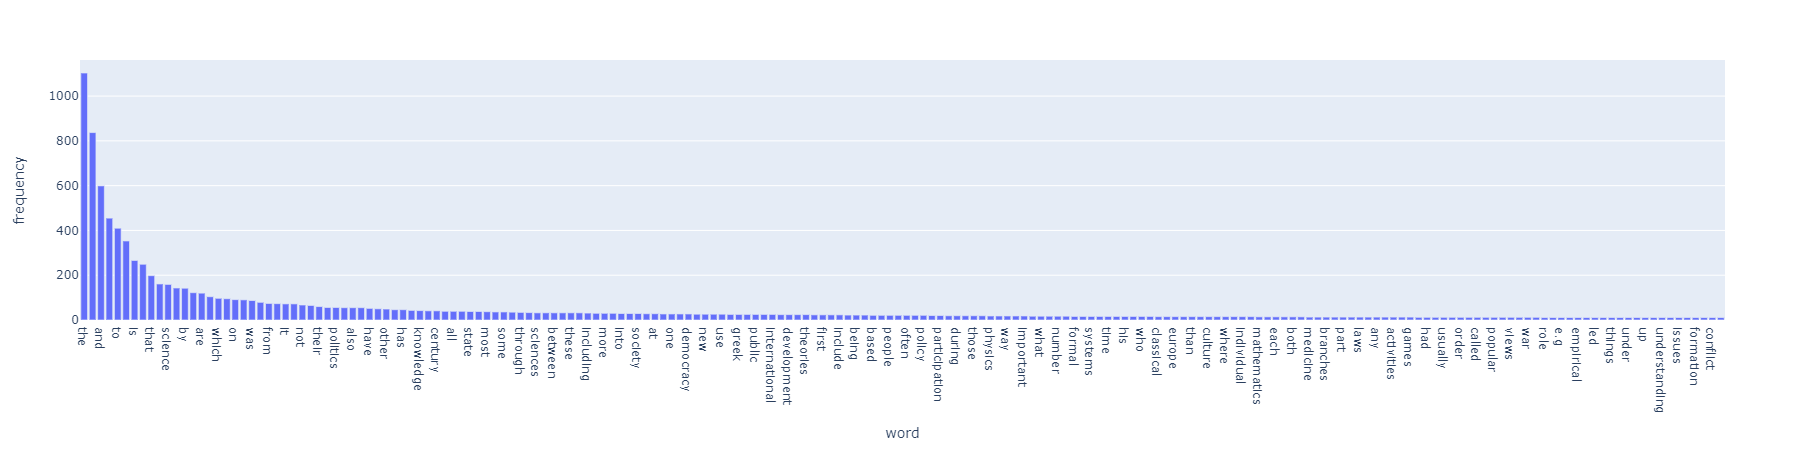

In [209]:
# plot figure
fig = px.bar(d, x="word", y="frequency")
fig.show()

In [217]:
# Don't really care about words like 'the', 'of', 'and' etc so use tf-idf to get rid of them

wiki_titles = ["Science", "Mathematics", "Sports"]
wiki_gen = get_wiki_iter(wiki_titles)

# first the term-frequency (tf) as out 'documents' vary greatly in length, this will be the augmented frequency

#                     F_t,d
# tf(t, d) = -----------------------
#             max{F_t',d : t'\in d}

def tf(t_count, max_count):
    return (t_count/max_count)

all_tfs = {}
for title, doc in zip(wiki_titles, wiki_gen):
    tfs = {}
    max_count = max(doc.values())
    for word in doc.keys():
        t_count = doc[word]
        tfs[word] = tf(t_count, max_count)
    all_tfs[title] = tfs


            
        


In [218]:
# now for idf: The inverse document frequency is a measure of how much information the word provides, i.e., if it's common or rare across all documents.

#                         N
# idf(t, D) = log--------------------
#                |{d \in D : t\in d}|

def idf(num_docs, num_docs_with_term):
    return np.log(num_docs/num_docs_with_term)

all_idf = []
visited_words = []
org_corpus = {k:v.keys() for k, v in zip(wiki_titles, wiki_gen)}

num_docs = len(wiki_titles)
idfs = {}

for title, doc in zip(wiki_titles, wiki_gen):
    for word in doc.keys():
        if word not in visited_words:
            word_count = 0
            for key in org_corpus.keys():
                if word in org_corpus[key]:
                    word_count += 1
            visited_words.append(word)
            idfs[word] = idf(num_docs, word_count)

        
    

In [219]:
all_tdidfs = {}
for doc_name in all_tfs.keys():
    all_tdidfs[doc_name] = {}
    for word in all_tfs[doc_name].keys():
        all_tdidfs[doc_name][word] = idfs[word] * all_tfs[doc_name][word]
    

In [220]:
wiki_page = "Science"

word_sorted = sorted(all_tdidfs[wiki_page], key=all_tdidfs[wiki_page].get, reverse=True)
freq_sorted = sorted(all_tdidfs[wiki_page].values(), reverse=True)
d =  {"word": word_sorted, "frequency": freq_sorted}


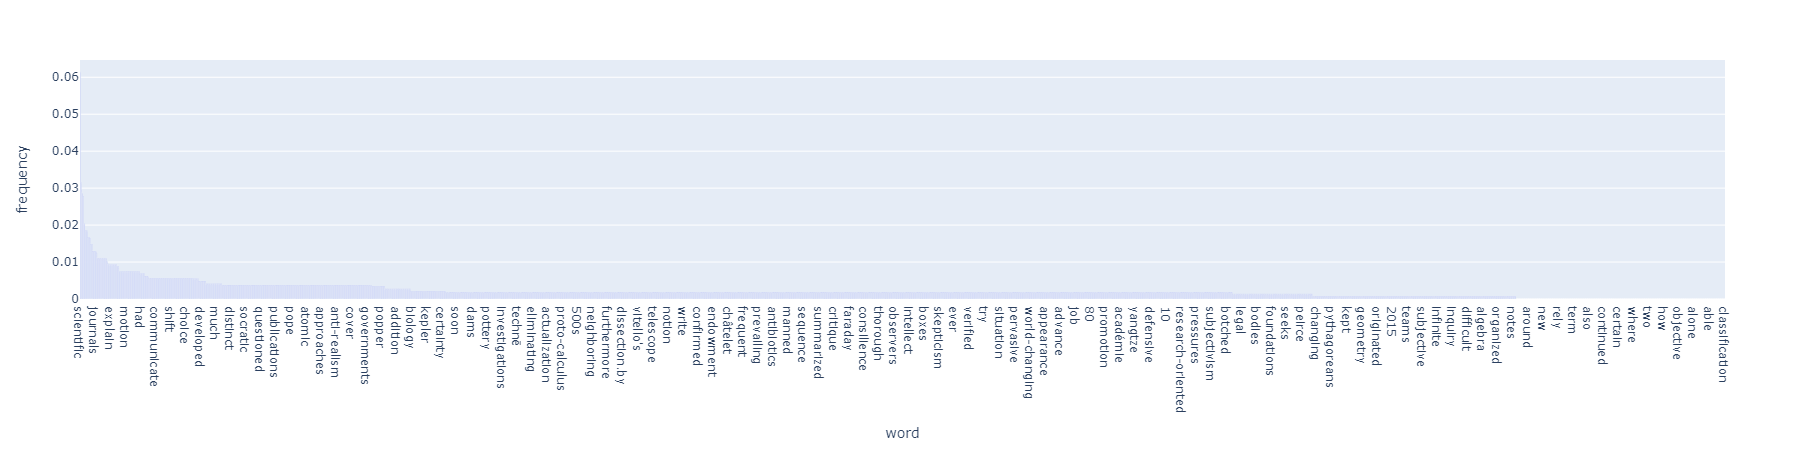

In [221]:
# plot figure
fig = px.bar(d, x="word", y="frequency")
fig.show()